<a href="https://colab.research.google.com/github/GugaKunkel/DeepLearning/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab10.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 8: Transfer Learning/Fine-Tuning

## Description

### Objective

- Gain experience fine-tuning pre-trained models to domain-specific applications.

### Deliverable

For this lab you will submit an ipython notebook via learning suite. The bulk of the work is in modifying fine-tuning a pre-trained ResNet. Fine-tuning the GPT-2 language model is pretty easy. The provided code works as is; you will just have to swap in your own text dataset.

### Grading

- 35% Create a dataset class for your own dataset
- 35% Create a network class that wraps a pretrained ResNet
- 20% Implement unfreezing in the network class
- 10% Fine-tune GPT-2 on your own dataset

### Tips
- Your life will be better if you download a dataset that already has the data in the expected format for ImageFolder (make sure to read the documentation!). The datasets recommended below are in the correct format.
- Get the CNN working on the provided dataset (bird species classification) before swapping in your own.
- For reference on freezing/unfreezing network weights, see [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c)
- Check PyTorch's documentation to learn the difference between `requires_grad=False` and `requires_grad_(False)`.
- For training GPT-2, first try the medium-size (355M parameter) model. If your Colab instance doesn't have enough GPU space, you may need to switch to the small-size (124M parameter) model, but the results will be less impressive.

In [ ]:
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import random

## 1 Fine-tune a ResNet for image classification

### 1.1 Find a dataset to fine-tune on, and make a Dataset class (1 hr.)

#### TODO:

- Inherit from torch.utils.data.Dataset
- Use a [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder)
- Don't spend too long finding another dataset. Some suggestions that you are free to use:
 - https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
 - https://www.kaggle.com/puneet6060/intel-image-classification


#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()
# Next, install the Kaggle API client.
!pip install -q kaggle
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Mar  8 19:25 kaggle.json


3. Copy the desired dataset locally

In [ ]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
!kaggle datasets download -d akash2907/bird-species-classification
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

100% 1.37G/1.37G [00:34<00:00, 31.9MB/s]
100% 1.37G/1.37G [00:35<00:00, 42.1MB/s]
100% 748M/750M [00:19<00:00, 39.2MB/s]
100% 750M/750M [00:19<00:00, 39.8MB/s]


#### Make the Dataset class
See the implementation below for reference, and implement a dataset class for the dataset you choose.

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, zip_file='bird-species-classification.zip', size=256, train=True, upload=False):
        super(BirdDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # Resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        if train:
            # The bird-species dataset mistakenly has a train_data folder inside of train_data
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'train_data', 'train_data'), transform=transforms.Compose([transforms.ToTensor()]))
        else:
            self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, 'test_data', 'test_data'), transform=transforms.Compose([transforms.ToTensor()]))

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

bird_data = BirdDataset()

Extracting bird-species-classification.zip
Resizing images


In [ ]:
class DogDataset(Dataset):
    def __init__(self, zip_file='stanford-dogs-dataset.zip', size=256, train=True, upload=False):
        super(DogDataset, self).__init__()

        self.train = train
        extract_dir = os.path.splitext(zip_file)[0]
        if not os.path.exists(extract_dir):
            os.makedirs(extract_dir)
            self.extract_zip(zip_file, extract_dir)
            # Resize the images - originally they are high resolution. We could do this
            # in the DataLoader, but it will read the full-resolution files from disk
            # every time before resizing them, making training slow
            self.resize(extract_dir, size=size)

        postfix = 'train' if train else 'test'

        dataset = datasets.ImageFolder(os.path.join(extract_dir, 'images', 'Images'), transform=transforms.Compose([transforms.ToTensor()]))
        total_len = len(dataset)
        indices = list(range(total_len))
        random.shuffle(indices)  # Shuffle the indices

        if train:
            train_indices = [indices[i] for i in range(0, int(0.8 * total_len), 3)]  # Take every third index from random 80% of the data for training
            self.dataset_folder = torch.utils.data.Subset(dataset, train_indices)
        else:
            test_indices = [indices[i] for i in range(int(0.8 * total_len), total_len, 3)]  # Take every third index from random 20% of the data for testing
            self.dataset_folder = torch.utils.data.Subset(dataset, test_indices)

        # train_size = int(0.8 * len(dataset))
        # test_size = len(dataset) - train_size
        # train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        # self.dataset_folder = train_dataset if train else test_dataset

    def extract_zip(self, zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

    def resize(self, path, size=256):
        """Resizes all images in place"""
        print("Resizing images")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            if 'annotations' in root:
                continue
            for item in files:
                name = os.path.join(root, item)
                if os.path.isfile(name):
                    im = Image.open(name)
                    im = ImageOps.fit(im, (size, size))
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

dog_data = DogDataset()

Extracting stanford-dogs-dataset.zip
Resizing images


### 1.2 Wrap a pretrained ResNet in an `nn.Module` (30 min)

#### TODO:

- Make a model class that inherits from `nn.Module`
- Wrap a pretrained ResNet and swap out the last layer of that network with a layer that maps to the number of classes in your new dataset

#### Make your model class

In [9]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes, start_frozen=False):
        super(CustomResNet, self).__init__()

        # Load the model - make sure it is pre-trained
        self.resnet = resnet152(pretrained=True)

        if start_frozen:
            self.freeze()

        # Replace the last fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes, bias=True)

    def freeze(self):
        # Freeze all parameters of the pre-trained ResNet
        for param in self.resnet.parameters():
            param.requires_grad = False

    def unfreeze(self, n_layers):
      total_layers = len(list(self.resnet.parameters()))

      start_index = total_layers - n_layers

      for i, param in enumerate(self.resnet.parameters()):
        if i >= start_index:
          param.requires_grad = True


    def forward(self, x):
      return self.resnet(x)

### 1.3 Read through and run this training loop

In [10]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""

    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc.item()

def evaluate(model, objective, val_loader, device):
    """Gets average accuracy and loss for the validation set"""

    val_losses = 0
    val_accs = 0
    batches = 0
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:

            batches += 1

            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses += val_loss.item()
            val_accs += val_acc

    model.train()

    return val_losses/batches, val_accs/batches

In [11]:
def train(start_frozen=False, model_unfreeze=0):
    """Fine-tunes a CNN
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
    epochs = 20
    # Start with a very low learning rate
    lr = .00005
    val_every = 50
    num_classes = 120
    batch_size = 40
    device = torch.device('cuda:0')

    # Data
    train_dataset = DogDataset(upload=True, train=True)
    val_dataset = DogDataset(upload=True, train=False)
    train_loader = DataLoader(train_dataset,
                              shuffle=False,
                              num_workers=8,
                              batch_size=batch_size)
    val_loader = DataLoader(val_dataset,
                              shuffle=False,
                              num_workers=8,
                              batch_size=batch_size)

    # Model
    model = CustomResNet(num_classes, start_frozen=start_frozen).to(device)

    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    cnt = 0
    for epoch in range(epochs):

        # Implement model unfreezing
        if epoch < model_unfreeze:
          model.unfreeze(epoch + 1)

        for x, y_truth in train_loader:

            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc)
            train_losses.append(train_loss.item())

            if cnt % val_every == 0:
                val_loss, val_acc = evaluate(model, objective, val_loader, device)
                val_losses.append(val_loss)
                val_accs.append(val_acc)

            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1

    pbar.close()
    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=val_every), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=val_every), val_losses, label='Val Loss')
    plt.legend()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 160MB/s]
train loss:1.7870, train accuracy:0.7500.: 100%|██████████| 2760/2760 [20:11<00:00,  2.28it/s]


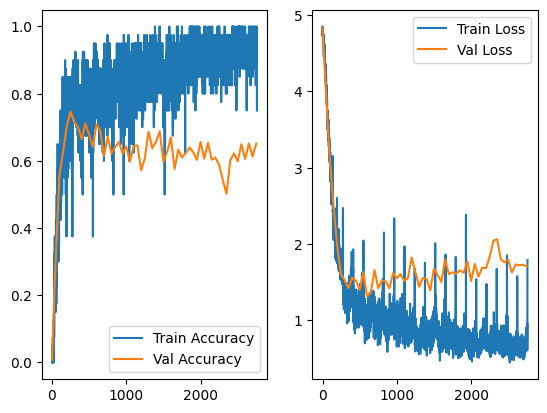

In [ ]:
train(start_frozen=False, model_unfreeze=0)

### 1.4 Implement Unfreezing (1 hr)

#### Description

Unfreezing is a technique that can be helpful when fine tuning a CNN for a more difficult task with a large amount of data.

The idea is that if we allow the network to tweak the earliest layers immediately, before the last FCL has been trained at all, the earliest layers will forget all of the useful features that they learned in order  to provide features that are helpful for the (untrained) FCL.

So, rather than training all of the model weights at once, we learn the last fully connected layer, then train that layer together with the second-to-last layer, gradually adding layers until we reach the first layer.

#### TODO:

- Modify your model's parameters by setting the `requires_grad` attributes to `False`. (but keep `requires_grad = True` for the last layer).
- Add a member function to you model class that allows the user to unfreeze weights in the training loop. See [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) for reference.
- Modify your training loop to add logic that calls the `unfreeze` function of the model class: unfreeze one layer (a convolutional layer or linear layer, not the sequential or bottleneck layers) every epoch.
- Call your train function to fine-tune the ResNet on your dataset.

#### Call your train function

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 166MB/s]
train loss:1.9117, train accuracy:1.0000.: 100%|██████████| 2760/2760 [10:17<00:00,  4.47it/s]


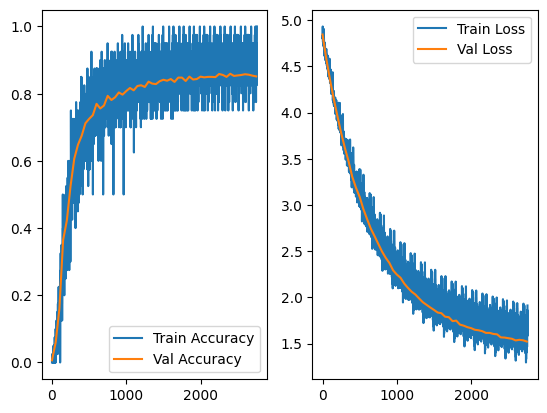

In [12]:
train(start_frozen=True, model_unfreeze=1)

You may not see any improvement for your classification task, but unfreezing can help convergence for more difficult image classification tasks.

## 2 Fine-tune a language model - (15 min)

In this section you will use the gpt-2-simple package [here](https://github.com/minimaxir/gpt-2-simple) to fine-tune the GPT-2 language model on a domain of your choice.

### 2.1 Generate text from an the pretrained GPT-2 model

#### Run this code to generate text from a pretrained model

In [14]:
!pip install gpt-2-simple

# the transformers package is built on top of Tensorflow, and the default TF version
# for Colab will soon switch to 2.x. We remedy this with the following magic method

import gpt_2_simple as gpt2
import os
import tensorflow.compat.v1 as tf

In [15]:
# This line is necessary to be able to run a new tf session
tf.reset_default_graph()
# The medium-sized model. IF you run out of memory, try "124M" instead
model_name = "124M"
if not os.path.isdir(os.path.join("models", model_name)):
	print(f"Downloading {model_name} model...")
	gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/124M/

sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, model_name=model_name)
gpt2.generate(sess, model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 3.97Git/s]                                                     
Fetching encoder.json: 1.05Mit [00:00, 4.58Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 3.87Git/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:08, 59.0Mit/s]                                  
Fetching model.ckpt.index: 1.05Mit [00:00, 1.33Git/s]                                               
Fetching model.ckpt.meta: 1.05Mit [00:00, 6.70Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 6.85Mit/s]


Loading pretrained model models/124M/model.ckpt
So how does it work?

The simple answer is simply that the Muslim Brotherhood will have banned the fact that the alleged state-sponsored "rebels" are on a mission to overthrow the leaders of the West. The Muslim Brotherhood is more than happy to oblige.

According to a statement issued by the Egyptian military, the Brotherhood is not under any obligation to defend the West, nor that it has any ties to any foreign power. The Brotherhood is not likely to join any international organization, such as the United Nations, which would require a direct involvement in such an event.

The Brotherhood has a different outlook on the Western military intervention in the Middle East.

"The Brotherhood views the West as a mongrel organization whose mission is to eliminate the State of Israel and its political leaders, which it views as a threat to the security of the people," the statement said. "The Brotherhood has long been advocating a peaceful resol

### 2.2 Download a text dataset

#### TODO:

- Use the provided functions to download your own text dataset
- [Project Gutenberg](https://www.gutenberg.org/) is a nice starting point for raw text corpora

#### Download Dataset

In [32]:
import zipfile
import os
from torchvision import datasets

def extract_zip(zip_path, remove_finished=True):
    print('Extracting {}'.format(zip_path))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path.replace('.zip', ''))
    if remove_finished:
        os.remove(zip_path)

def download_dataset(url, root='../data'):
    if not os.path.exists(os.path.join(root, 'text')):
        os.makedirs(os.path.join(root), exist_ok=True)
        datasets.utils.download_url(url, root, 'text.zip', None)
        extract_zip(os.path.join(root, 'text.zip'))
    return os.path.join(root, 'text')

##########################################
# Set the url for your dataset here,
# move the dataset to the desired location
##########################################
url = 'https://www.gutenberg.org/files/36/36-0.zip'
download_dataset(url)
!mv /data/text/36-0.txt /data/text/war.txt
!ls ../data/text

100%|██████████| 139796/139796 [00:00<00:00, 1888967.75it/s]

Extracting ../data/text.zip


war.txt


### 2.3 Fine-tune GPT-2 on your own dataset

#### TODO:

- Swap out the dataset parameter with the path to your dataset

#### Train on your dataset

In [33]:
# This line is necessary to be able to run a new tf session if one has already been run
tf.reset_default_graph()
# Start a session
sess = gpt2.start_tf_sess()
# Fine tune `model_name` on `data`
###################################
# Swap out the `dataset` parameter with the path to your text dataset
###################################
gpt2.finetune(sess,
              dataset='../data/text/war.txt',
              model_name=model_name,
              restore_from='latest',
              steps=500)   # steps is max number of training steps

gpt2.generate(sess, run_name='run1')

Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


dataset has 89415 tokens
Training...
[1 | 4.47] loss=3.68 avg=3.68
[2 | 5.19] loss=3.73 avg=3.71
[3 | 5.91] loss=3.74 avg=3.72
[4 | 6.63] loss=3.62 avg=3.69
[5 | 7.34] loss=3.61 avg=3.68
[6 | 8.06] loss=3.66 avg=3.67
[7 | 8.78] loss=3.63 avg=3.67
[8 | 9.50] loss=3.43 avg=3.64
[9 | 10.22] loss=3.42 avg=3.61
[10 | 10.94] loss=3.10 avg=3.56
[11 | 11.66] loss=3.38 avg=3.54
[12 | 12.37] loss=3.43 avg=3.53
[13 | 13.09] loss=3.33 avg=3.51
[14 | 13.81] loss=3.05 avg=3.48
[15 | 14.53] loss=3.42 avg=3.48
[16 | 15.25] loss=3.21 avg=3.46
[17 | 15.97] loss=3.05 avg=3.43
[18 | 16.69] loss=3.38 avg=3.43
[19 | 17.41] loss=3.17 avg=3.41
[20 | 18.13] loss=3.14 avg=3.40
[21 | 18.84] loss=3.25 avg=3.39
[22 | 19.56] loss=2.29 avg=3.33
[23 | 20.28] loss=2.76 avg=3.31
[24 | 21.00] loss=2.86 avg=3.29
[25 | 21.72] loss=3.10 avg=3.28
[26 | 22.44] loss=3.40 avg=3.28
[27 | 23.15] loss=3.09 avg=3.27
[28 | 23.87] loss=3.30 avg=3.28
[29 | 24.59] loss=2.65 avg=3.25
[30 | 25.31] loss=3.10 avg=3.25
[31 | 26.03] loss=3.